<a href="https://www.kaggle.com/code/kavishchaudhary1003/used-cars-regression-multiple-models?scriptVersionId=120395418" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



import os
for dirname, _, filenames in os.walk('/kaggle/input/user-car-prices-barcelona-2022'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/user-car-prices-barcelona-2022/used_cars_data.csv


In [3]:
df = pd.read_csv('/kaggle/input/user-car-prices-barcelona-2022/used_cars_data.csv')

#### Removing the first column

In [4]:
df = df.iloc[: ,1:10]

#### Checking for null and duplicated values

In [ ]:
df.isna().sum()
df.duplicated().sum()

#### Summary for the data

In [5]:
df.describe()

,price (eur),year,mileage (kms)
count,792.000000,792.000000,792.000000
mean,15973.383838,2016.404040,83228.833333
std,6984.338370,2.452251,46202.118589
min,4990.000000,2004.000000,1258.000000
25%,11355.000000,2015.000000,47145.500000
50%,14990.000000,2017.000000,80065.500000
75%,18490.000000,2018.000000,116321.750000
max,82580.000000,2021.000000,220000.000000


#### Printing the value counts for the train set

In [6]:
for i in df.columns:
    print(df[i].value_counts())

SEAT          84
Ford          60
BMW           57
Volkswagen    51
Peugeot       48
Audi          44
Citroen       42
Toyota        42
Kia           39
Renault       39
Nissan        37
Mercedes      36
Opel          31
Hyundai       23
Fiat          22
Mini          20
Mazda         18
Dacia         14
Jeep          12
Land          11
Mitsubishi     9
Abarth         9
Jaguar         6
Honda          6
Suzuki         4
Porsche        4
Alfa           4
Volvo          4
Smart          3
Lexus          3
Ssangyong      2
Skoda          2
Subaru         2
Cupra          2
DS             1
Chevrolet      1
Name: brand, dtype: int64
Leon                    32
Ibiza                   31
Focus                   21
Golf                    17
Yaris                   15
                        ..
XE                       1
Optima                   1
Benz Clase GLE Coupé     1
Rapid                    1
S5                       1
Name: model, Length: 206, dtype: int64
14990    47
10990    39
99

#### Checking the distribution of categorical predictor variables

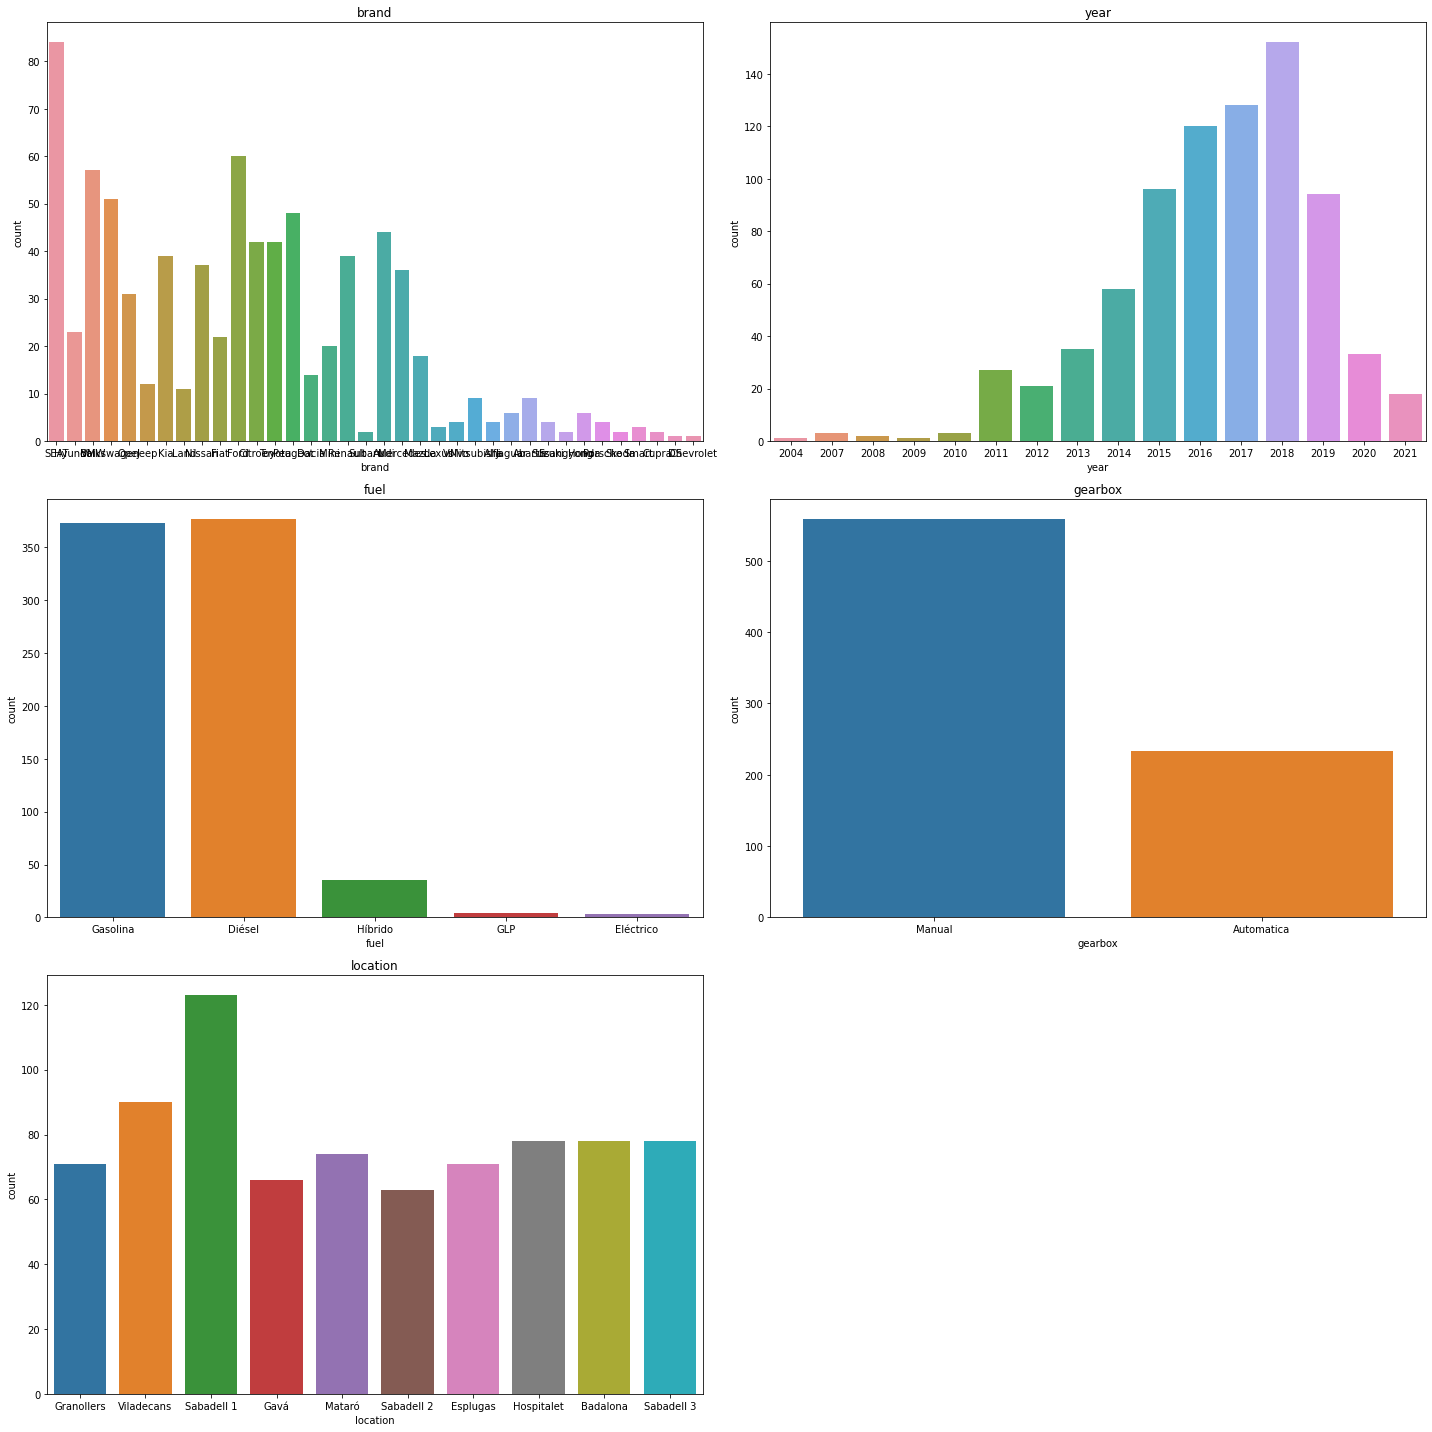

In [7]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    if i < len(['brand', 'year','fuel', 'gearbox', 'location']):
        sns.countplot(x= df[(['brand', 'year','fuel', 'gearbox', 'location'][i])], ax= ax)
        ax.set_title(['brand','year','fuel', 'gearbox', 'location'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

#### Checking the distribution of the continuous predictor variable

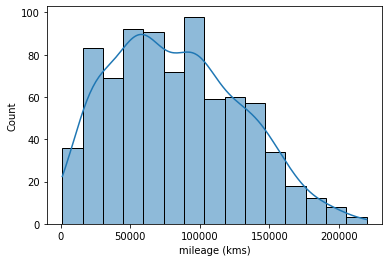

In [8]:
sns.histplot(x= df['mileage (kms)'], kde = True)
plt.show()

#### Checking the distribution of the target variable

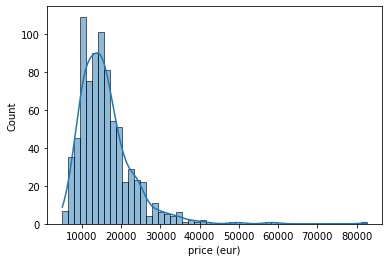

In [9]:
sns.histplot(x = df['price (eur)'], kde = True)
plt.show()

#### one hot encoding

In [10]:
df = pd.get_dummies(df)

#### Isolation Forest to detect outliers

In [11]:
Is = IsolationForest()
Is.fit(df)
df['anamoly']= Is.predict(df)
df.anamoly.value_counts()
df.drop(columns = ['anamoly'], inplace = True)

#### Separating the predictors and target variable

In [12]:
y = df['price (eur)']
df.drop(columns = ['price (eur)'], inplace = True)

#### Scaling the continuous variable

In [13]:
scaler = StandardScaler()
mileage_reshaped = np.array(df['mileage (kms)']).reshape(-1,1)
df['mileage_scaled'] = scaler.fit_transform(mileage_reshaped)

In [14]:
df.drop(columns = ['mileage (kms)'], inplace = True)

#### Defining a function model_eval which uses RandomizedSearchCV for parameter tuning 
* Nested cross val used for training and testing to reduce the bias.
* tqdm used to display a progress bar when performing parameter tuning.
* Storing the score during each iteration and printing the mean score. 

In [ ]:
def model_eval(model, param, df, y):
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    scores = []
    random = RandomizedSearchCV(model, param, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = inner_cv, random_state = 0)
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(df, y):
                trainx, testx = df.iloc[train_index], df.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx, trainy)
                predy = random.best_estimator_.predict(testx)
                scores.append(np.sqrt(mean_squared_error(testy, predy, squared = False)))
            pbar.update()
    print(random.best_params_)
    print('Average RMSE', np.mean(scores))

### Ridge used for predictions
Average RMSE 72.26148415347923

Parameters tuned :
* alpha- regularization strength
* max_iter- max no. of iterations
* solver- svd, cholesky, lsqr and lbfgs are the 4 options available for the regressor

In [ ]:
model = Ridge()
alpha = np.logspace(-6, 1, 10)
max_iter = np.array(range(100000, 10000000))
solver = ['svd', 'cholesky', 'lsqr','lbfgs']
param = {'alpha': alpha, 'max_iter': max_iter, 'solver': solver}
model_eval(model,param, df,y)

### Lasso used for predictions
Average RMSE 74.84613718408403

Parameters tuned :
* alpha- regularization strength
* max_iter- max no. of iterations

In [ ]:
model = Lasso()
alpha = np.linspace(0, 1, 100)
max_iter = np.array(range(100000, 10000000))
param = {"alpha": alpha, 'max_iter': max_iter}
model_eval(model,param, df,y)

### ElasticNet used for predictions
Average RMSE 70.52940589808036

Parameters tuned :
* alpha- regularization strength
* max_iter- max no. of iterations

In [ ]:
model = ElasticNet()
alpha = np.linspace(0, 1, 100)
max_iter = np.array(range(100000, 10000000))
param = {'alpha': alpha, 'max_iter': max_iter}
model_eval(model,param, df,y)

### Decision Tree used for predictions
Average RMSE 72.77479673930934

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- squared_error, friedman_mse, poisson and absolute_error are the 4 options available for regressor

In [ ]:
model = DecisionTreeRegressor()
criterion = ['squared_error', 'friedman_mse', 'poisson', 'absolute_error']
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
param = {'criterion' : criterion, 'min_samples_split' : min_samples_split, 'max_depth': max_depth}
model_eval(model,param, df,y)

### Random Forest used for predictions
Average RMSE 70.67890128076506

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- squared_error, friedman_mse, poisson and absolute_error are the 4 options available for regressor
* n_estimators- no. of trees in the forest

In [ ]:
model = RandomForestRegressor()
criterion = ['squared_error', 'friedman_mse', 'poisson', 'absolute_error']
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
n_estimators = np.array(range(100, 1000, 10))
param = {'criterion': criterion, 'min_samples_split': min_samples_split, 'max_depth': max_depth, 'n_estimators': n_estimators}
model_eval(model,param, df,y)

### Ada Boost used for predictions
Average RMSE 76.3231611210198

Parameters tuned :
* learning_rate -Weight applied to each regressor at each boosting iteration
* n_estimators- no. of trees in the forest

In [ ]:
model = AdaBoostRegressor()
n_estimators = np.array(range(100, 1000,10))
learning_rate = np.linspace(0,1, 100)
param = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
model_eval(model,param, df,y)

# The best model
### Bagging Regressor used for predictions
Average RMSE 69.25401973940127

Parameters tuned :
* n_estimators- no. of trees in the forest
* max_features- no. of features


In [ ]:
model = BaggingRegressor()
n_estimators = np.array(range(100,1000,10))
max_features = np.array(range(1, 955))
param = {'n_estimators': n_estimators, 'max_features': max_features}
model_eval(model,param, df,y)

### Extra Trees used for predictions
Average RMSE 71.25356376418858

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- squared_error, friedman_mse, poisson and absolute_error are the 4 options available for regressor
* n_estimators- no. of trees in the forest

In [ ]:
model = ExtraTreesRegressor()
criterion = ['squared_error', 'friedman_mse', 'poisson', 'absolute_error']
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
n_estimators = np.array(range(100, 1000,10))
param = {'criterion': criterion, 'min_samples_split': min_samples_split, 'max_depth': max_depth, 'n_estimators': n_estimators}
model_eval(model,param, df,y)